In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers 
from sklearn.ensemble import GradientBoostingClassifier

# Analysis libs
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [9]:
X_drop_columns = ['Class', 'Category', 'svcscan.interactive_process_services', 'handles.nport', 'pslist.nprocs64bit']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [11]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 52)
y_train shape: (41017,)
X_test shape: (17579, 52)
y_test shape: (17579,)


In [28]:
gb = GradientBoostingClassifier(learning_rate=1.0, random_state=1)
clf = gb.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.9032352439232514
Test accuracy: 0.8551112122418795


In [29]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8790,    0,    0,    0],
       [   0, 1963,  420,  554],
       [   0,  318, 2285,  403],
       [   1,  529,  322, 1994]])

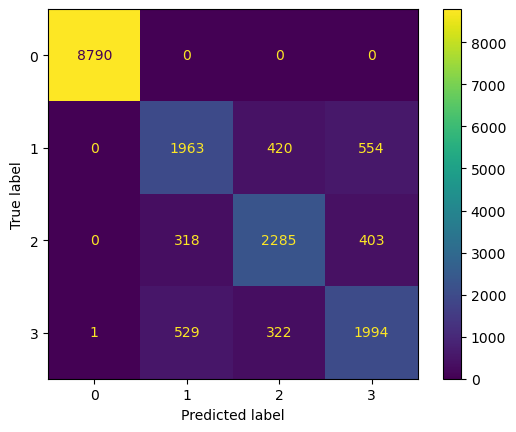

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()